# Analyse et compréhension du classement du Vendée Globe 2020
**Données mises à jour le 10 janvier 2021**

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup as bs
from pytz import timezone
from sklearn import linear_model
import datetime
import requests
import multiprocessing
import geopandas
import re

## Quel est l'état actuel de la course ?
### Téléchargement du dernier classement

In [2]:
def get_soup(url):
    r = requests.get(url)
    return bs(r.content.decode('utf-8'), 'lxml')

In [3]:
def get_ranking(date=None):
    # Si aucune date est spécifiée, on récupère le dernier classement disponible
    if date is None:
        r = requests.get('https://www.vendeeglobe.org/fr/classement')
        r_content = bs(r.content.decode('utf-8'), 'lxml')
        link_tags = r_content.find_all('a', {'class': 'rankings__download'})
        ranking_url = 'https://www.vendeeglobe.org' + link_tags[0]['href']
    else:
        ranking_url = 'https://www.vendeeglobe.org/download-race-data/vendeeglobe_' + date + '.xlsx'

    df = pd.read_excel(ranking_url, skiprows=2, skipfooter=4, header=2)
    df = df.drop(columns='Unnamed: 0').dropna().fillna(' ')
    # On ne garde que les données depuis le dernier classement
    df = df.drop(columns=[
        'Cap\nHeading',
        'Vitesse\nSpeed', 
        'VMG\nVMG', 
        'Distance\nDistance',
        'Cap\nHeading.2', 
        'Vitesse\nSpeed.2', 
        'VMG\nVMG.2',
        'Distance\nDistance.2'
    ])
    df.columns = [
        'Rang', 
        'Voile', 
        'Skipper/Bateau', 
        'Heure', 
        'Latitude', 
        'Longitude', 
        'Cap',
        'Vitesse',
        'VMG', 
        'Distance',
        'DTF',
        'DTL'
    ]
    df['Voile'] = df['Voile'].apply(lambda x: x.split('\n')[1])
    df['Skipper/Bateau'] = df['Skipper/Bateau'].str.replace('\n', ' / ')

    # Conversion des coordonnées en valeurs décimales
    def convert_coordinates(s):
        degrees = re.split('[°\']', s)
        return (float(degrees[0]) + (float(degrees[1])/60)) * (-1 if degrees[2] == 'S' or degrees[2] == 'W' else 1)
    df['Latitude'] = df['Latitude'].apply(convert_coordinates)
    df['Longitude'] = df['Longitude'].apply(convert_coordinates)

    # Retrait des unités
    df['Cap'] = df['Cap'].astype(str).str[:-1]
    for col in ['Heure', 'Vitesse', 'VMG', 'Distance', 'DTF', 'DTL']:
        df[col] = df[col].apply(lambda x: x.split(' ')[0]).astype(int, errors='ignore')

    # Conversion des colonnes en float
    for col in ['Cap', 'Vitesse', 'VMG', 'Distance', 'DTF', 'DTL']:
        df[col] = df[col].astype(float)

    if date is not None:
        df['Date'] = datetime.datetime.strptime(date, '%Y%m%d_%H%M00')
        
    return df

ranking_df = get_ranking()
ranking_df

,Rang,Voile,Skipper/Bateau,Heure,Latitude,Longitude,Cap,Vitesse,VMG,Distance,DTF,DTL
0,1,FRA 17,Yannick Bestaven / Maître Coq IV,14:30,-26.762833,-39.083333,17.0,15.1,15.0,45.3,4884.0,0.0
1,2,FRA 79,Charlie Dalin / APIVIA,14:30,-31.040667,-38.333833,39.0,9.3,8.9,28.0,5108.2,224.2
2,3,FRA 1000,Damien Seguin / Groupe APICIL,14:30,-32.540333,-36.550000,332.0,13.0,8.7,39.1,5160.5,276.6
3,4,FRA 59,Thomas Ruyant / LinkedOut,14:30,-32.265333,-39.190667,42.0,9.3,8.8,28.0,5192.6,308.7
4,5,FRA 18,Louis Burton / Bureau Vallée 2,14:30,-33.949333,-35.918667,355.0,15.6,14.3,46.9,5229.6,345.6
5,6,FRA 09,Benjamin Dutreux / OMIA - Water Family,14:30,-36.178667,-35.582333,355.0,16.5,15.1,49.4,5350.5,466.6
6,7,FRA 01,Jean Le Cam / Yes we Cam !,14:30,-36.153167,-36.570833,357.0,16.5,15.2,49.4,5365.0,481.0
7,8,MON 10,Boris Herrmann / Seaexplorer - Yacht Club De M...,14:30,-36.308000,-36.742500,352.0,18.0,16.0,54.0,5376.5,492.6
8,9,ITA 34,Giancarlo Pedote / Prysmian Group,14:30,-36.465667,-37.199000,346.0,16.9,14.1,50.8,5393.0,509.0
9,10,FRA 53,Maxime Sorel / V And B Mayenne,14:30,-39.043333,-34.232833,8.0,15.5,15.2,46.4,5493.2,609.2


* _DTF_ : Distance To Finish
* _DTL_ : Distance To Leader

### Où sont les voiliers ?

Afin de déterminer la position et la trajectoire des voiliers, on récupère l'historique de tous les classements.

In [4]:
# Récupération de la liste des classements
def get_ranking_history():
    df = pd.DataFrame()
    soup = get_soup('https://www.vendeeglobe.org/fr/classement')
    date_list = soup.find_all('option')[1:]
    for date in date_list:
        temp_df = get_ranking(date.attrs['value'])
        df = pd.concat([df, temp_df], ignore_index=True)

    return df

In [5]:
ranking_history = get_ranking_history()
ranking_history['Rang'] = ranking_history['Rang'].astype(int)
ranking_history

,Rang,Voile,Skipper/Bateau,Heure,Latitude,Longitude,Cap,Vitesse,VMG,Distance,DTF,DTL,Date
0,1,FRA 17,Yannick Bestaven / Maître Coq IV,14:30,-26.762833,-39.083333,17.0,15.1,15.0,45.3,4884.0,0.0,2021-01-10 14:00:00
1,2,FRA 79,Charlie Dalin / APIVIA,14:30,-31.040667,-38.333833,39.0,9.3,8.9,28.0,5108.2,224.2,2021-01-10 14:00:00
2,3,FRA 1000,Damien Seguin / Groupe APICIL,14:30,-32.540333,-36.550000,332.0,13.0,8.7,39.1,5160.5,276.6,2021-01-10 14:00:00
3,4,FRA 59,Thomas Ruyant / LinkedOut,14:30,-32.265333,-39.190667,42.0,9.3,8.8,28.0,5192.6,308.7,2021-01-10 14:00:00
4,5,FRA 18,Louis Burton / Bureau Vallée 2,14:30,-33.949333,-35.918667,355.0,15.6,14.3,46.9,5229.6,345.6,2021-01-10 14:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11192,27,FRA 72,Alexia Barrier / TSE - 4myplanet,15:30,46.430500,-1.815333,357.0,0.0,0.0,2789.4,24295.4,1.6,2020-11-08 14:00:00
11193,28,FRA 27,Isabelle Joschke / MACSF,15:26,46.416333,-1.803667,358.0,0.0,0.0,2788.5,24295.5,1.6,2020-11-08 14:00:00
11194,29,FRA 4,Sébastien Simon / ARKEA PAPREC,15:29,46.429167,-1.812167,357.0,0.0,0.0,2789.3,24295.5,1.6,2020-11-08 14:00:00
11195,30,FRA 50,Miranda Merron / Campagne de France,15:28,46.423167,-1.805667,358.0,0.0,0.0,2788.9,24295.6,1.7,2020-11-08 14:00:00


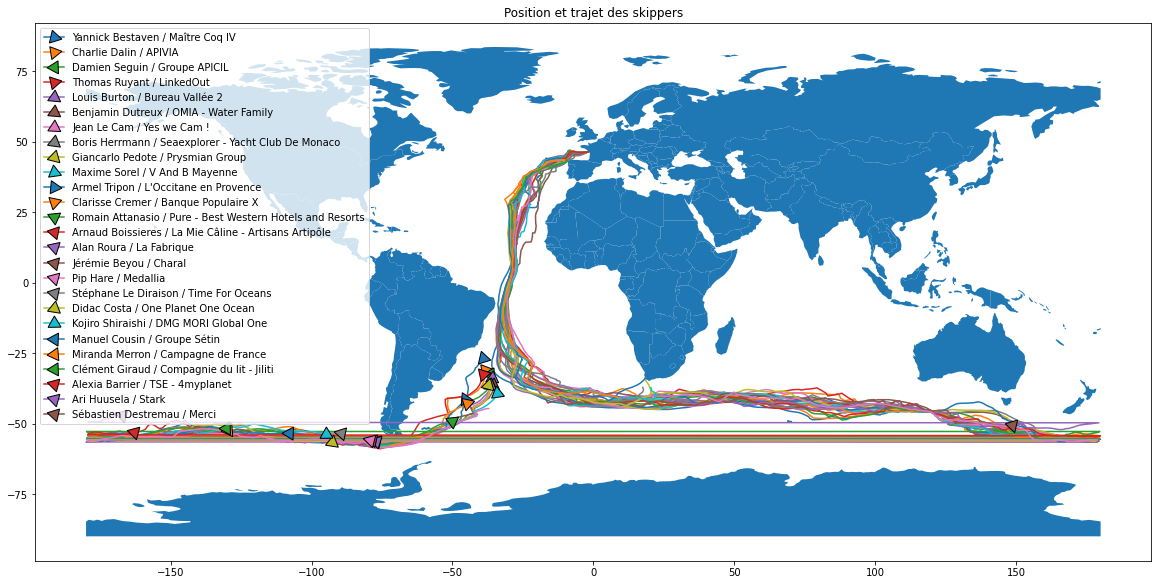

In [6]:
fig, ax = plt.subplots(figsize=(20, 10))

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax)

# Affichage des trajectoires
for skipper in ranking_history['Skipper/Bateau'].unique():
    tab = ranking_history.loc[(ranking_history['Skipper/Bateau'] == skipper)]
    plt.plot(tab['Longitude'], tab['Latitude'])

# Remise à zéro du cycle de couleurs de matplotlib
plt.gca().set_prop_cycle(None)

# Affichage de la position actuelle des bateaux
for index, row in ranking_df.iterrows():
    ax.plot(
        row['Longitude'], 
        row['Latitude'], 
        marker=(3,0, float(row['Cap'])), 
        markersize=15, 
        markeredgewidth=1,
        markeredgecolor='black',
        label=row['Skipper/Bateau'])

ax.legend(loc='upper left')
plt.title('Position et trajet des skippers')
plt.show()


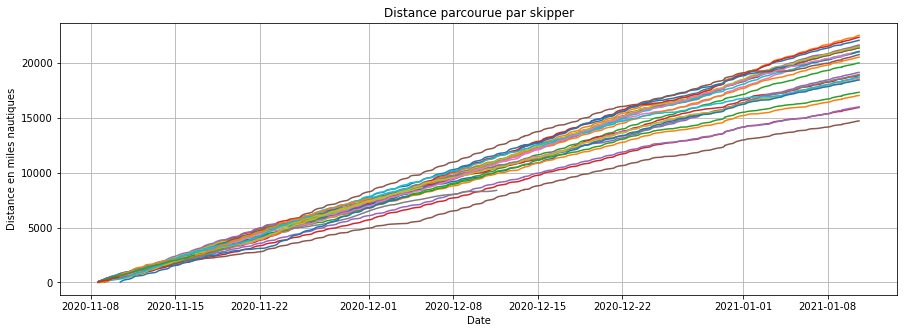

In [7]:
plt.figure(figsize=(15, 5))
for skipper in ranking_history['Skipper/Bateau'].unique():
    tab = ranking_history.loc[ranking_history['Skipper/Bateau'] == skipper]
    tab = tab.loc[tab['Distance'] < 1000] # On retire la première valeur du classement qui est aberrante
    plt.plot(tab.iloc[::-1]['Date'], tab['Distance'].cumsum(), label=skipper)

#plt.legend(loc='upper left')
plt.grid(True, 'both', 'both')
plt.title('Distance parcourue par skipper')
plt.xlabel('Date')
plt.ylabel('Distance en miles nautiques')
plt.show()

### Evolution du podium

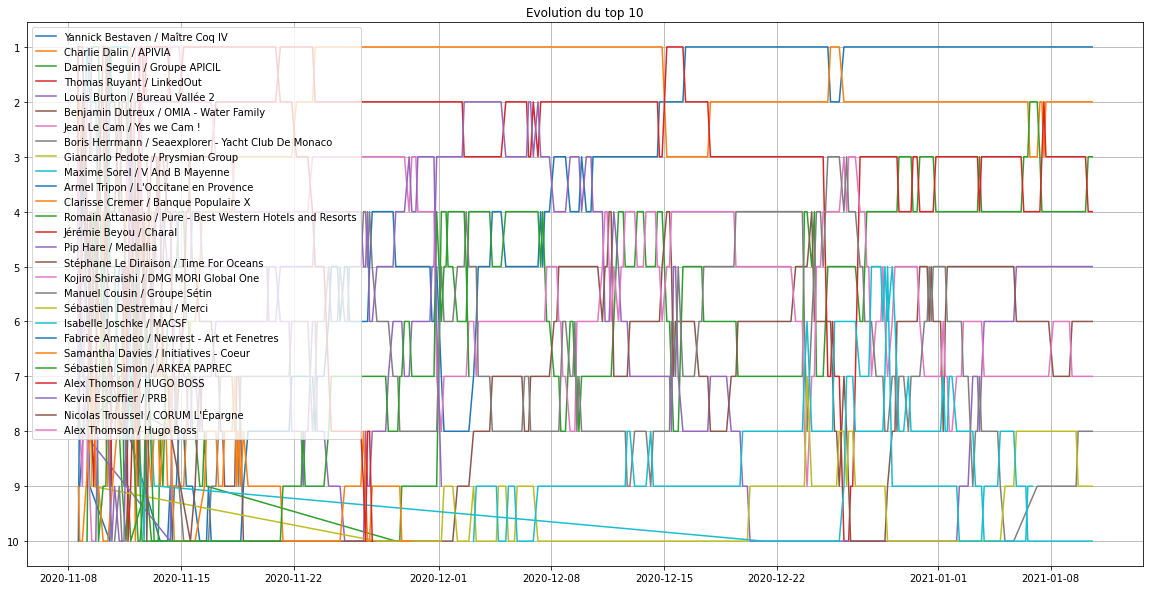

In [8]:
plt.figure(figsize=(20, 10))

for skipper in ranking_history['Skipper/Bateau'].unique():
    tab = ranking_history.loc[(ranking_history['Skipper/Bateau'] == skipper) & (ranking_history['Rang'] <= 10)]
    if len(tab) > 0:
        plt.plot(tab['Date'], tab['Rang'], label=skipper)

plt.gca().invert_yaxis()

plt.yticks(np.arange(1, 11, step=1))
plt.grid(True, 'major', 'both')
plt.legend(loc='upper left')
plt.title('Evolution du top 10')

plt.show()

### Focus sur le leader
#### Qui est en tête ?

In [9]:
leader = ranking_df.loc[ranking_df['Rang'] == '1'].iloc[0]['Skipper/Bateau']
print(leader + ' est actuellement en tête de la course.')

Yannick Bestaven / Maître Coq IV est actuellement en tête de la course.


#### Quelle est sa vitesse ?

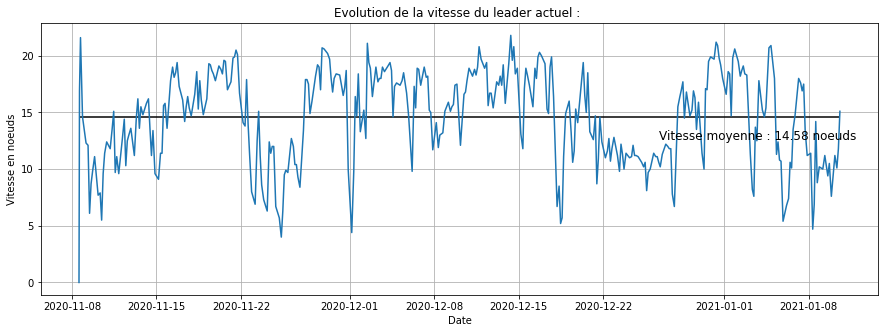

In [10]:
first = ranking_history.loc[ranking_history['Skipper/Bateau'] == leader]
plt.figure(figsize=(15, 5))
plt.plot(first['Date'], first['Vitesse'].astype(float))
plt.hlines(first['Vitesse'].mean(), first['Date'].min(), first['Date'].max(), colors='black')
plt.text(
    x=first['Date'].max()-datetime.timedelta(days=15), 
    y=first['Vitesse'].mean()-2, 
    s='Vitesse moyenne : {:.2f} noeuds'.format(first['Vitesse'].mean()),
    fontsize=12)
plt.grid(True, 'major', 'both')
plt.title('Evolution de la vitesse du leader actuel : ')
plt.xlabel('Date')
plt.ylabel('Vitesse en noeuds')
plt.show()

#### Quelle est son avance ?

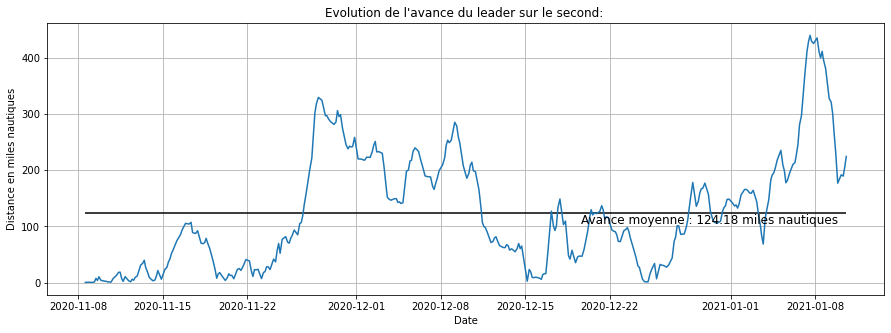

In [11]:
second = ranking_history.loc[ranking_history['Rang'] == 2]
plt.figure(figsize=(15, 5))
plt.plot(second['Date'], second['DTL'].astype(float))
plt.hlines(second['DTL'].mean(), second['Date'].min(), second['Date'].max(), colors='black')
plt.text(
    x=second['Date'].max()-datetime.timedelta(days=22), 
    y=second['DTL'].mean()-20, 
    s='Avance moyenne : {:.2f} miles nautiques'.format(second['DTL'].mean()),
    fontsize=12)
plt.grid(True, 'major', 'both')
plt.title('Evolution de l\'avance du leader sur le second: ')
plt.xlabel('Date')
plt.ylabel('Distance en miles nautiques')
plt.show()

## Comment expliquer ce classement ?

Afin d'obtenir des statistiques intéressantes sur chaque coureur, on calcule les moyennes de leurs différentes statistiques.

In [12]:
mean_df = ranking_history.groupby('Skipper/Bateau').mean()
mean_df

,Rang,Latitude,Longitude,Cap,Vitesse,VMG,Distance,DTF,DTL
Skipper/Bateau,,,,,,,,,
Alan Roura / La Fabrique,16.511749,-29.571191,-2.452600,128.159269,12.597389,11.336554,57.330548,16192.811749,1687.819582
Alex Thomson / HUGO BOSS,7.236111,-10.823558,-19.509230,156.708333,13.715278,11.300000,54.657639,20517.677778,362.643056
Alex Thomson / Hugo Boss,10.166667,45.765722,-6.838764,253.583333,11.008333,8.966667,270.691667,24124.116667,18.808333
Alexia Barrier / TSE - 4myplanet,25.433420,-22.181982,24.036413,137.613577,10.586945,9.463446,48.963969,17649.496345,3144.507833
Ari Huusela / Stark,26.759791,-20.845554,23.221709,137.362924,10.516971,9.112272,49.112010,17830.500522,3325.508877
Armel Tripon / L'Occitane en Provence,17.751958,-26.712120,-5.617171,129.765013,13.775457,12.284334,62.290339,15888.749347,1383.759008
Arnaud Boissieres / La Mie Câline - Artisans Artipôle,18.644737,-27.451745,-4.944506,130.526316,12.506842,11.326842,57.103684,16409.289474,1981.348684
Benjamin Dutreux / OMIA - Water Family,7.381201,-31.076704,-9.598923,125.229765,14.057702,12.623238,63.174151,14918.845692,413.851436
Boris Herrmann / Seaexplorer - Yacht Club De Monaco,7.710183,-31.343466,-10.417607,123.725849,14.274151,12.719060,63.632637,14900.434987,395.443342


On s'intéresse à la VMG. Acronyme pour "Velocity Made Good", il s'agit d'une représentation de la vitesse du voiliée pondérée par son cap, et permet donc de déterminer sa vitesse sur le tracé de la course. Pour confirmer cela, nous vérifions si la VMG est corrélée au classement.

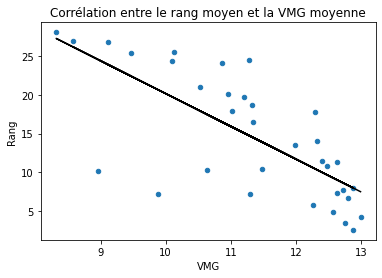

In [13]:
regr = linear_model.LinearRegression().fit(np.array(mean_df['VMG']).reshape(-1, 1), mean_df['Rang'])

mean_df.plot.scatter(x='VMG', y='Rang')
plt.plot(mean_df['VMG'], regr.predict(np.array(mean_df['VMG']).reshape(-1, 1)), color='black')
plt.title('Corrélation entre le rang moyen et la VMG moyenne')
plt.show()

In [14]:
np.corrcoef(mean_df['VMG'], mean_df['Rang'])[0][1]

-0.7246511810137929

On remarque que la VMG est très corrélée au classement. On peut ainsi en déduire que la VMG permet de déterminer le rang d'un skipper : plus sa VMG est élevée, plus il sera haut dans le classement.

### Quelles caractéristiques des bateaux peuvent influer sur sa vitesse ?

Nous essayons de déterminer si des caractéristiques spécifiques des voiliers influent positivement ou négativement sur la VMG d'un voilier. 

Pour cela, récupérons quelques caractéristiques des voiliers depuis le site du Vendée Globe.

In [15]:
def get_boats_specs():
    df = pd.DataFrame()

    soup = get_soup('https://www.vendeeglobe.org/fr/glossaire')
    boat_list = soup.find_all('div', {'class': 'boats-list__popup-infos'})

    for boat in boat_list:
        temp_df = pd.DataFrame()
        temp_df['Nom'] = pd.Series(boat.find('h3').text)
        for li in boat.find('ul').find_all('li'):
            spec = li.text.split(' : ')
            temp_df[spec[0]] = pd.Series(spec[1])
        df = pd.concat([df, temp_df])

    # Retrait des unités et conversion en valeurs numériques
    for col in ['Longueur', 'Largeur', 'Tirant d\'eau', 'Déplacement (poids)', 'Hauteur mât', 'Surface de voiles au près', 'Surface de voiles au portant']:
        df[col] = df[col].apply(lambda x: re.sub(' ?[A-Za-z]+[2²]?', '', x).replace(',', '.')).astype(float, errors='ignore')
    
    return df

get_boats_specs()

,Nom,Numéro de voile,Anciens noms du bateau,Architecte,Chantier,Date de lancement,Longueur,Largeur,Tirant d'eau,Déplacement (poids),Nombre de dérives,Hauteur mât,Voile quille,Surface de voiles au près,Surface de voiles au portant
0,NEWREST - ART & FENÊTRES,FRA 56,"No Way Back, Vento di Sardegna",VPLP/Verdier,Persico Marine,01 Août 2015,18.28,5.85,4.5,7,foils,29.0,monotype,320.0,570.0
0,PURE - Best Western®,FRA 49,"Gitana Eighty, Synerciel, Newrest-Matmut",Bruce Farr Design,Southern Ocean Marine (Nouvelle Zélande),08 Mars 2007,18.28,5.80,4.5,9,2,28.0,acier forgé,280.0,560.0
0,TSE - 4MYPLANET,FRA72,"Famille Mary-Etamine du Lys, Initiatives Coeur...",Marc Lombard,MAG France,01 Mars 1998,18.28,5.54,4.5,9,2,29.0,acier,260.0,580.0
0,Maître CoQ IV,17,Safran 2 - Des Voiles et Vous,Verdier - VPLP,CDK Technologies,12 Mars 2015,18.28,5.80,4.5,8,foils,29.0,acier mécano soudé,310.0,550.0
0,CHARAL,08,NaN,VPLP,CDK Technologies,18 Août 2018,18.28,5.85,4.5,8,foils,29.0,acier,320.0,600.0
0,LA MIE CÂLINE - ARTISANS ARTIPÔLE,FRA 14,"Ecover3, Président, Gamesa, Kilcullen Voyager-...",Owen Clarke Design LLP - Clay Oliver,Hakes Marine - Mer Agitée,03 Août 2007,18.28,5.65,4.5,7.9,foils,29.0,basculante avec vérin,300.0,610.0
0,BUREAU VALLEE 2,18,Banque Populaire VIII,Verdier - VPLP,CDK Technologies,09 Juin 2015,18.28,5.80,4.5,7.6,foils,28.0,acier,300.0,600.0
0,ONE PLANET ONE OCEAN,ESP 33,Kingfisher - Educacion sin Fronteras - Forum M...,Owen Clarke Design,Martens Yachts,02 Février 2000,18.28,5.30,4.5,8.9,2,26.0,acier,240.0,470.0
0,GROUPE SÉTIN,FRA 71,"Paprec-Virbac2, Estrella Damm, We are Water, L...",Bruce Farr Yacht Design,Southern Ocean Marine (Nouvelle-Zélande),02 Février 2007,18.28,5.80,4.5,9,2 asymétriques,28.5,basculante sur vérin hydraulique,270.0,560.0
0,BANQUE POPULAIRE X,FRA30,Macif - SMA,Verdier - VPLP,CDK - Mer Agitée,01 Mars 2011,18.28,5.70,4.5,7.7,2,29.0,acier forgé,340.0,570.0


Combinons les données de caractéristiques des voiliers aux données de statistiques moyennes de la course.

In [16]:
merge_mean_df = mean_df.copy().reset_index()
merge_mean_df['Jointure'] = merge_mean_df['Skipper/Bateau'].apply(lambda x: x.split(' / ')[1].lower())
merge_boat_df = get_boats_specs()
merge_boat_df['Nom'] = merge_boat_df['Nom'].str.lower()

specs_df = pd.merge(
    left=merge_mean_df,
    right=merge_boat_df,
    left_on='Jointure',
    right_on='Nom',
    how='left'
).drop(columns=['Nom', 'Jointure'])

#### Importance des foils

Les _foils_ sont des appendices attachés à la coque d'un voilier. Prenant généralement le profil d'une aile d'avion, les foils fournissent de la portance au voilier, lui permettant de 'décoller' de la surface de l'eau au delà d'une certaine vitesse. Cela permet de grandement réduire la traînée générée par le frottement du voilier avec l'eau.

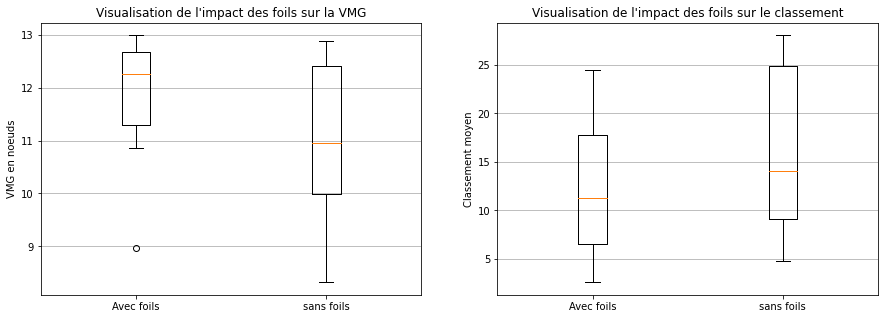

In [17]:
with_foils = specs_df.loc[specs_df['Nombre de dérives'] == 'foils']
without_foils = specs_df.loc[specs_df['Nombre de dérives'] != 'foils']

fig, ax = plt.subplots(1,2, figsize=(15, 5))
ax[0].boxplot([with_foils['VMG'].astype(float), without_foils['VMG'].astype(float)], labels=['Avec foils', 'sans foils'])
ax[0].title.set_text('Visualisation de l\'impact des foils sur la VMG')
ax[0].set_ylabel('VMG en noeuds')
ax[1].boxplot([with_foils['Rang'].astype(float), without_foils['Rang'].astype(float)], labels=['Avec foils', 'sans foils'])
ax[1].title.set_text('Visualisation de l\'impact des foils sur le classement')
ax[1].set_ylabel('Classement moyen')
for a in ax:
    a.grid(True, 'both', 'y')
fig.show()

In [18]:
print('{} voiliers sur {}, soit {:.1f} % sont équipés de foils.'.format(len(with_foils), len(specs_df), len(with_foils)*100/len(specs_df)))

15 voiliers sur 34, soit 44.1 % sont équipés de foils.


On remarque que la distribution des voiliers équipés de foils ont une plus grande vitesse que ceux qui n'en sont pas équipés, et tendent à être plus haut dans le classement. Cependant, même s'ils constituent un avantage, on remarque que les foils sont présent sur toute l'étendue du classement.

#### Autres caractéristiques

Ayant déterminé que la présence de foils joue un rôle important sur la vitesse et donc le classement, essayons de déterminer si d'autres caractéristiques des bateaux ont de l'importance. On s'intéresse ici aux caractéristiques numériques.

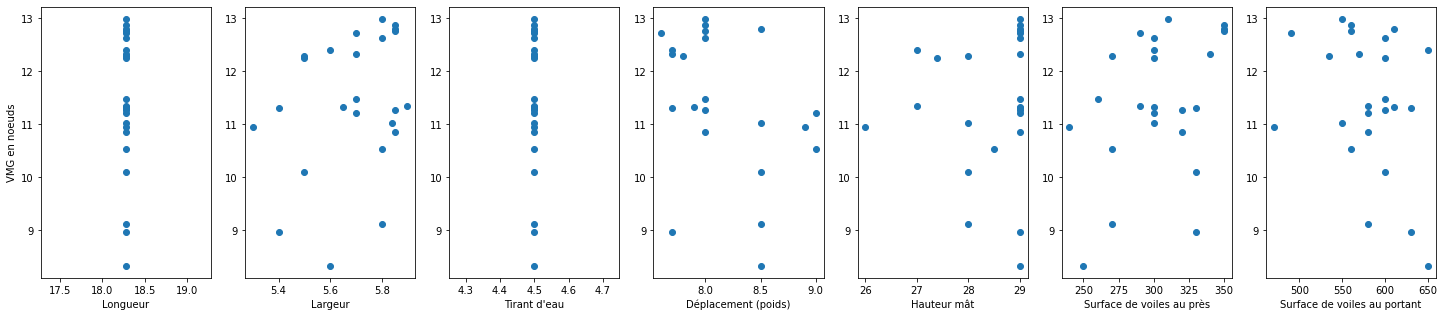

In [19]:
fig, ax = plt.subplots(1, 7, figsize=(25,5))

cols = [
    'Longueur', 
    'Largeur', 
    'Tirant d\'eau', 
    'Déplacement (poids)', 
    'Hauteur mât', 
    'Surface de voiles au près', 
    'Surface de voiles au portant']
for i in range(len(ax)):
    tmp = specs_df[['VMG', cols[i]]].loc[specs_df[cols[i]] != '']
    ax[i].scatter(tmp[cols[i]].astype(float), tmp['VMG'].astype(float))
    ax[i].set_xlabel(cols[i])

ax[0].set_ylabel('VMG en noeuds')

fig.show()

On ne décèle sur ces graphiques aucune corrélation entre la VMG et les caractéristiques numériques des bateaux. On peut donc en conclure que, d'après les caractéristiques que nous connaissons de notre jeu de données, la présence de foils est celle qui a le plus d'impact sur la vitesse, et donc le classement du skipper.